# 4. Scattering calculations

This example demonstrates the basic principles of performing scattering calcualtions with ARTS. Populations of particles that scatter radiation are referred to as *scattering species*. Each scattering species defines a mapping from one or several fields of *scattering species properties* to *scattering properties* which form the input to the actual scattering calculation.

## Set up a 1D atmosphere

In [1]:
import numpy as np
import pyarts

ws = pyarts.Workspace()
ws.surface_fieldSetPlanetEllipsoid(option="Earth")
ws.surface_field[pyarts.arts.SurfaceKey("t")] = 295.0
ws.atmospheric_fieldRead(
    toa=100e3, basename="planets/Earth/afgl/tropical/", missing_is_zero=1
)
ws.atmospheric_fieldIGRF(time="2000-03-11 14:39:37")

## Add a field of scattering species properties

For this example, we will use scatterers with a Henyey-Greenstein phase function to represent ice particles. We will use two *scattering species properties* to represent the scattering species *ice*: The extinction and the single-scattering albed (SSA). The ice extinction and SSA thus become atmospheric fields. Below we define scattering-species-property object that identify these fields.

### Ice

In [2]:
ice_extinction = pyarts.arts.ScatteringSpeciesProperty("ice", pyarts.arts.ParticulateProperty("Extinction"))
ice_ssa = pyarts.arts.ScatteringSpeciesProperty("ice", pyarts.arts.ParticulateProperty("SingleScatteringAlbedo"))

We then define a GriddedField3 representing the ice extinction and single-scattering albedo and add it to ``atm_field`` of the workspace.

In [3]:
grids = ws.atmospheric_field["t"].data.grids
z = grids[0]
ice_extinction_profile = np.zeros_like(z)
ice_extinction_profile[(z > 5e3) * (z < 15e3)] = 1.0
ice_extinction_profile = pyarts.arts.GriddedField3(data=ice_extinction_profile[..., None, None], grids=grids)
ws.atmospheric_field[ice_extinction] = ice_extinction_profile

ice_ssa_profile = np.zeros_like(z)
ice_ssa_profile[(z > 5e3) * (z < 15e3)] = 0.5
ice_ssa_profile = pyarts.arts.GriddedField3(data=ice_ssa_profile[..., None, None], grids=grids)
ws.atmospheric_field[ice_ssa] = ice_ssa_profile

### Rain

In [4]:
rain_extinction = pyarts.arts.ScatteringSpeciesProperty("rain", pyarts.arts.ParticulateProperty("Extinction"))
rain_ssa = pyarts.arts.ScatteringSpeciesProperty("rain", pyarts.arts.ParticulateProperty("SingleScatteringAlbedo"))

In [5]:
rain_extinction_profile = np.zeros_like(z)
rain_extinction_profile[z < 5e3] = 1.0
rain_extinction_profile = pyarts.arts.GriddedField3(data=rain_extinction_profile[..., None, None], grids=grids)
ws.atmospheric_field[rain_extinction] = rain_extinction_profile

rain_ssa_profile = np.zeros_like(z)
rain_ssa_profile[z < 5e3] = 0.5
rain_ssa_profile = pyarts.arts.GriddedField3(data=rain_ssa_profile[..., None, None], grids=grids)
ws.atmospheric_field[rain_ssa] = rain_ssa_profile

## Create the scattering species

In [6]:
from pyarts.arts import HenyeyGreensteinScatterer, ArrayOfScatteringSpecies

hg_ice = HenyeyGreensteinScatterer(ice_extinction, ice_ssa, 0.5)
hg_rain = HenyeyGreensteinScatterer(rain_extinction, rain_ssa, 0.0)
scattering_species = ArrayOfScatteringSpecies()
scattering_species.add(hg_ice)
scattering_species.add(hg_rain)

## Extracting scattering properties

We can now extract bulk scattering properties from the scattering species.

### Ice

We can extract the ice phase function from the combind scattering species by calculating the bulk-scattering properties at an altitude above 5 km. To check the consistency of the Henyey-Greenstein scatterer, we extract the data in gridded and spectral representation and ensure that they are the same when both are converted to gridded representation.

In [11]:
atm_pt = ws.atmospheric_field.at(11e3, 0.0, 0.0)
f_grid = np.array([89e9])
bsp = scattering_species.get_bulk_scattering_properties_tro_spectral(atm_pt, f_grid, 32, 1)
pm_spectral = bsp.phase_matrix

In [12]:
za_scat_grid = pm_spectral.to_gridded().get_za_scat_grid()
bsp = scattering_species.get_bulk_scattering_properties_tro_gridded(atm_pt, f_grid, za_scat_grid, 1)
pm_gridded = bsp.phase_matrix

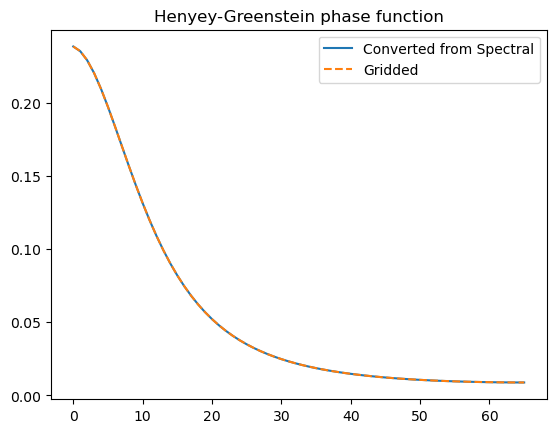

In [13]:
import matplotlib.pyplot as plt
plt.plot(pm_spectral.to_gridded().flatten(), label="Converted from Spectral")
plt.plot(pm_gridded.flatten(), ls="--", label="Gridded")
plt.title("Henyey-Greenstein phase function")
plt.legend()

### Rain

Similarly, we can extract the phase function for rain by calculating the bulk-scattering properties at a lower point in the atmosphere.

In [22]:
atm_pt = ws.atmospheric_field.at(4e3, 0.0, 0.0)
bsp = scattering_species.get_bulk_scattering_properties_tro_spectral(atm_pt, f_grid, 32, 1)
pm_spectral = bsp.phase_matrix

In [23]:
za_scat_grid = pm_spectral.to_gridded().get_za_scat_grid()
bsp = scattering_species.get_bulk_scattering_properties_tro_gridded(atm_pt, f_grid, za_scat_grid, 1)
pm_gridded = bsp.phase_matrix

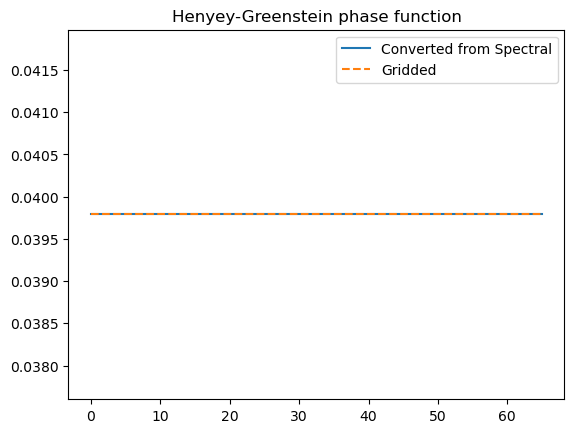

In [24]:
import matplotlib.pyplot as plt
plt.plot(pm_spectral.to_gridded().flatten(), label="Converted from Spectral")
plt.plot(pm_gridded.flatten(), ls="--", label="Gridded")
plt.title("Henyey-Greenstein phase function")
plt.legend()